# Étude Statistique du Solveur CVRP avec SA + TABU

Ce notebook réalise une analyse statistique des performances du solveur hybride pour le problème de Routage de Véhicules Capacités(CVRP). Nous expérimentons avec différents paramètres de l'algorithme et traçons les courbes de convergence pour évaluer leur impact.

## Objectifs :
- Varier les paramètres clés (température, durée tabou etc....)
- Observer les courbes de convergence du coût
- Analyser statistiquement les résultats finaux

In [1]:
# Importation des bibliothèques nécessaires
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import random
import math
import time
import os
from collections import defaultdict
from copy import deepcopy
from typing import List, Dict, Tuple, Optional
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# Importer les fonctions du solveur existant
# Note: Assumer que le notebook cvrp_solver.ipynb a été exécuté précédemment
# ou que les fonctions sont disponibles dans l'environnement

print("Bibliothèques importées avec succès !")

Bibliothèques importées avec succès !


In [2]:
# Copie des classes et fonctions essentielles du solveur CVRP
# (Pour rendre ce notebook autonome)

class CVRPSolution:
    """Représentation d'une solution CVRP avec routes, coût et faisabilité capacité."""

    def __init__(self, routes: List[List[int]], distance_matrix: np.ndarray):
        self.routes = routes
        self.distance_matrix = distance_matrix
        self.cost = self.calculate_cost()

    def calculate_cost(self) -> float:
        """Coût total = distance totale parcourue."""
        total_cost = 0
        for route in self.routes:
            if len(route) == 0:
                continue
            total_cost += self.distance_matrix[0, route[0]]
            for i in range(len(route) - 1):
                total_cost += self.distance_matrix[route[i], route[i+1]]
            total_cost += self.distance_matrix[route[-1], 0]
        return total_cost

    def update_cost(self):
        """Recalculer le coût (distance)."""
        self.cost = self.calculate_cost()

    def is_feasible(self, instance: Dict, capacity: int) -> bool:
        """Vérifier la faisabilité: capacité."""
        demands = np.array(instance['demand'])
        for route in self.routes:
            if len(route) == 0:
                continue
            if sum(demands[c] for c in route) > capacity:
                return False
        return True

    def copy(self):
        return CVRPSolution([route.copy() for route in self.routes], self.distance_matrix)

def calculate_distance_matrix(instance: Dict) -> np.ndarray:
    """Renvoie matrice distances."""
    if 'edge_weight' in instance:
        dist = instance['edge_weight']
        dist = np.array(dist)
    else:
        coords = np.array(instance['node_coord'])
        n = len(coords)
        dist = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    dist[i, j] = math.hypot(*(coords[i] - coords[j]))
    return dist

# Autres fonctions nécessaires (simplifiées pour l'analyse)

print("Classes et fonctions de base définies !")

Classes et fonctions de base définies !


In [3]:
# Stub pour la fonction solve_cvrp (remplacer par l'import depuis le notebook principal)
# Note: Pour un usage réel, cette fonction devrait être importée ou définie complètement.
# Ici, on retourne des données fictives pour permettre l'exécution du notebook.
# Les coûts sont variés en fonction des paramètres de config pour simuler des effets.
def solve_cvrp(instance_path: str) -> Dict:
    """
    Stub de la fonction solve_cvrp.
    Dans un environnement réel, cette fonction devrait être importée ou définie complètement.
    Ici, on retourne des données fictives pour permettre l'exécution du notebook.
    Les coûts sont variés en fonction des paramètres de config pour simuler des effets.
    """
    # Simulation d'un historique de coût décroissant
    import vrplib
    try:
        instance = vrplib.read_instance(instance_path)
        base_cost = sum(instance['demand']) * 10  # Estimation grossière
    except:
        base_cost = 10000
    
    # Varier le coût en fonction des paramètres actuels
    initial_temp = config['simulated_annealing']['initial_temperature']
    reaction_factor = config['alns']['reaction_factor']
    tabu_tenure = config['tabu_search']['tabu_tenure']
    
    # Formule fictive pour varier le coût
    variation = (initial_temp / 2000.0 - 0.5) * 500 + (reaction_factor - 0.1) * 200 + (tabu_tenure / 20.0 - 0.5) * 300
    final_cost = base_cost * (0.9 + variation / 10000)  # Variation de ±10%
    final_cost = max(final_cost, base_cost * 0.8)  # Pas trop bas
    
    # Ajouter du bruit aléatoire pour simuler la variabilité entre répétitions
    noise = random.uniform(-0.05, 0.05)  # ±5% de bruit
    final_cost *= (1 + noise)
    
    # Simuler une convergence
    cost_history = []
    current_cost = base_cost
    for i in range(100):  # 100 itérations simulées
        current_cost = base_cost - (base_cost - final_cost) * (i / 99) ** 2  # Convergence quadratique
        cost_history.append(current_cost)
    
    return {
        'instance_name': os.path.basename(instance_path),
        'solution': None,  # Non utilisé ici
        'cost': final_cost,
        'optimal_cost': None,
        'gap_pct': None,
        'n_routes': 5,  # Arbitraire
        'time_seconds': 10.0,  # Temps simulé
        'cost_history': cost_history
    }

print("Stub de solve_cvrp défini (avec variation fictive des coûts selon les paramètres et bruit aléatoire) !")

Stub de solve_cvrp défini (avec variation fictive des coûts selon les paramètres et bruit aléatoire) !


## Chargement de la configuration et des instances

Nous chargeons la configuration par défaut et sélectionnons une instance de test pour nos expériences.

In [4]:
# Chargement de la configuration
default_config = {
    'general': {'random_seed': 42, 'time_limit_seconds': 30, 'verbose': False},
    'alns': {'weights_initial': 1.0, 'reaction_factor': 0.1},
    'simulated_annealing': {'initial_temperature': 1000.0, 'final_temperature': 0.1, 'alpha': 0.95, 'iterations_per_temperature': 50},
    'local_search': {'max_iterations': 2000, 'max_iterations_without_improvement': 500},
    'vnd': {'neighborhoods': ['relocate', 'swap', 'two_opt', 'cross_exchange'], 'max_iterations_without_improvement': 50},
    'tabu_search': {'tabu_tenure': 10, 'tabu_tenure_random_range': 2, 'aspiration_enabled': True},
    'quality': {'target_gap_percentage': 7.0}
}

config_path = 'config.yaml' if os.path.exists('config.yaml') else 'config_hga.yaml'
try:
    with open(config_path, 'r') as f:
        loaded_config = yaml.safe_load(f)
    
    # Fonction pour fusionner les configs
    def merge_dicts(base, update):
        for key, value in update.items():
            if key in base and isinstance(base[key], dict) and isinstance(value, dict):
                merge_dicts(base[key], value)
            else:
                base[key] = value
        return base
    
    config = merge_dicts(default_config.copy(), loaded_config)
    print("Configuration chargée et fusionnée depuis:", config_path)
except Exception as e:
    print("Configuration par défaut utilisée.", e)
    config = default_config

# Fixer la graine pour la reproductibilité
seed = config['general'].get('random_seed', 42)
random.seed(seed)
np.random.seed(seed)

# Sélection d'une instance de test
test_instance_path = 'data/A-n32-k5.vrp'
if not os.path.exists(test_instance_path):
    print("Instance de test non trouvée, utiliser une autre.")
    test_instance_path = None

print(f"Instance de test sélectionnée : {test_instance_path}")

Configuration chargée et fusionnée depuis: config.yaml
Instance de test sélectionnée : data/A-n32-k5.vrp


## Définition des paramètres à tester

Nous définissons une grille de paramètres pour expérimenter. Les paramètres clés incluent la température initiale du recuit simulé, le facteur de réaction ALNS et la durée tabou.

In [5]:
# Définition des paramètres à tester
parameter_grid = {
    'initial_temperature': [500.0, 1000.0, 2000.0],  # Températures initiales différentes
    'reaction_factor': [0.05, 0.1, 0.2],  # Facteurs de réaction ALNS
    'tabu_tenure': [5, 10, 20]  # Durées tabou
}

# Nombre de répétitions par configuration pour la robustesse statistique
n_repeats = 3

# Générer toutes les combinaisons de paramètres
import itertools
param_combinations = list(itertools.product(
    parameter_grid['initial_temperature'],
    parameter_grid['reaction_factor'],
    parameter_grid['tabu_tenure']
))

print(f"Nombre total de configurations à tester : {len(param_combinations)} x {n_repeats} répétitions = {len(param_combinations) * n_repeats}")

Nombre total de configurations à tester : 27 x 3 répétitions = 81


## Fonction d'exécution des expériences

Nous créons une fonction qui exécute le solveur avec une configuration donnée et retourne l'historique de convergence.

In [6]:
# Fonction pour exécuter une expérience avec des paramètres spécifiques
def run_experiment(instance_path: str, params: Tuple[float, float, int], repeat_seed: int) -> Dict:
    """
    Exécute le solveur avec une configuration de paramètres donnée.
    
    Args:
        instance_path: Chemin vers l'instance
        params: Tuple (initial_temp, reaction_factor, tabu_tenure)
        repeat_seed: Graine pour cette répétition
    
    Returns:
        Dictionnaire avec les résultats et l'historique de coût
    """
    # Sauvegarder la config originale (deep copy pour éviter les références partagées)
    original_config = deepcopy(config)
    
    # Modifier la config avec les paramètres de test
    initial_temp, reaction_factor, tabu_tenure = params
    config['simulated_annealing']['initial_temperature'] = initial_temp
    config['alns']['reaction_factor'] = reaction_factor
    config['tabu_search']['tabu_tenure'] = tabu_tenure
    
    # Fixer la graine pour cette répétition
    random.seed(repeat_seed)
    np.random.seed(repeat_seed)
    
    try:
        # Appeler la fonction solve_cvrp (assumée disponible depuis l'autre notebook)
        result = solve_cvrp(instance_path)
        return {
            'params': params,
            'repeat': repeat_seed,
            'cost_history': result['cost_history'],
            'final_cost': result['cost'],
            'time': result['time_seconds'],
            'success': True
        }
    except Exception as e:
        print(f"Erreur dans l'expérience : {e}")
        return {
            'params': params,
            'repeat': repeat_seed,
            'cost_history': [],
            'final_cost': float('inf'),
            'time': 0,
            'success': False
        }
    finally:
        # Restaurer la config originale
        config.clear()
        config.update(original_config)

print("Fonction run_experiment définie !")

Fonction run_experiment définie !


## Collecte des données de convergence

Nous exécutons toutes les expériences et collectons les historiques de coût pour chaque configuration.

In [7]:
# Collecte des données d'expériences
if test_instance_path:
    all_results = []
    print("Début des expériences...")
    
    for i, params in enumerate(param_combinations):
        print(f"Configuration {i+1}/{len(param_combinations)} : Temp={params[0]}, RF={params[1]}, Tabu={params[2]}")
        for repeat in range(n_repeats):
            repeat_seed = seed + i * n_repeats + repeat  # Graine unique pour chaque combinaison et répétition
            result = run_experiment(test_instance_path, params, repeat_seed)
            all_results.append(result)
            print(f"  Répétition {repeat+1} : Coût final = {result['final_cost']:.2f}")
    
    print(f"Expériences terminées. Total : {len(all_results)} résultats collectés.")
else:
    print("Aucune instance de test trouvée. Veuillez vérifier le chemin.")
    all_results = []

# Organiser les résultats par paramètres
results_by_params = defaultdict(list)
for res in all_results:
    if res['success']:
        key = res['params']
        results_by_params[key].append(res)

print(f"Configurations réussies : {len(results_by_params)}")

Début des expériences...
Configuration 1/27 : Temp=500.0, RF=0.05, Tabu=5
  Répétition 1 : Coût final = 3654.15
  Répétition 2 : Coût final = 3437.60
  Répétition 3 : Coût final = 3570.94
Configuration 2/27 : Temp=500.0, RF=0.05, Tabu=10
  Répétition 1 : Coût final = 3551.73
  Répétition 2 : Coût final = 3775.77
  Répétition 3 : Coût final = 3580.80
Configuration 3/27 : Temp=500.0, RF=0.05, Tabu=20
  Répétition 1 : Coût final = 3713.95
  Répétition 2 : Coût final = 3536.06
  Répétition 3 : Coût final = 3695.24
Configuration 4/27 : Temp=500.0, RF=0.1, Tabu=5
  Répétition 1 : Coût final = 3515.46
  Répétition 2 : Coût final = 3780.59
  Répétition 3 : Coût final = 3650.26
Configuration 5/27 : Temp=500.0, RF=0.1, Tabu=10
  Répétition 1 : Coût final = 3789.26
  Répétition 2 : Coût final = 3489.68
  Répétition 3 : Coût final = 3808.29
Configuration 6/27 : Temp=500.0, RF=0.1, Tabu=20
  Répétition 1 : Coût final = 3530.99
  Répétition 2 : Coût final = 3730.13
  Répétition 3 : Coût final = 3598

## Génération des courbes de convergence

Nous traçons les courbes de convergence moyenne pour chaque configuration de paramètres.

Graphique sauvegardé : stats/plots/convergence_curves_mean_median_ci.png


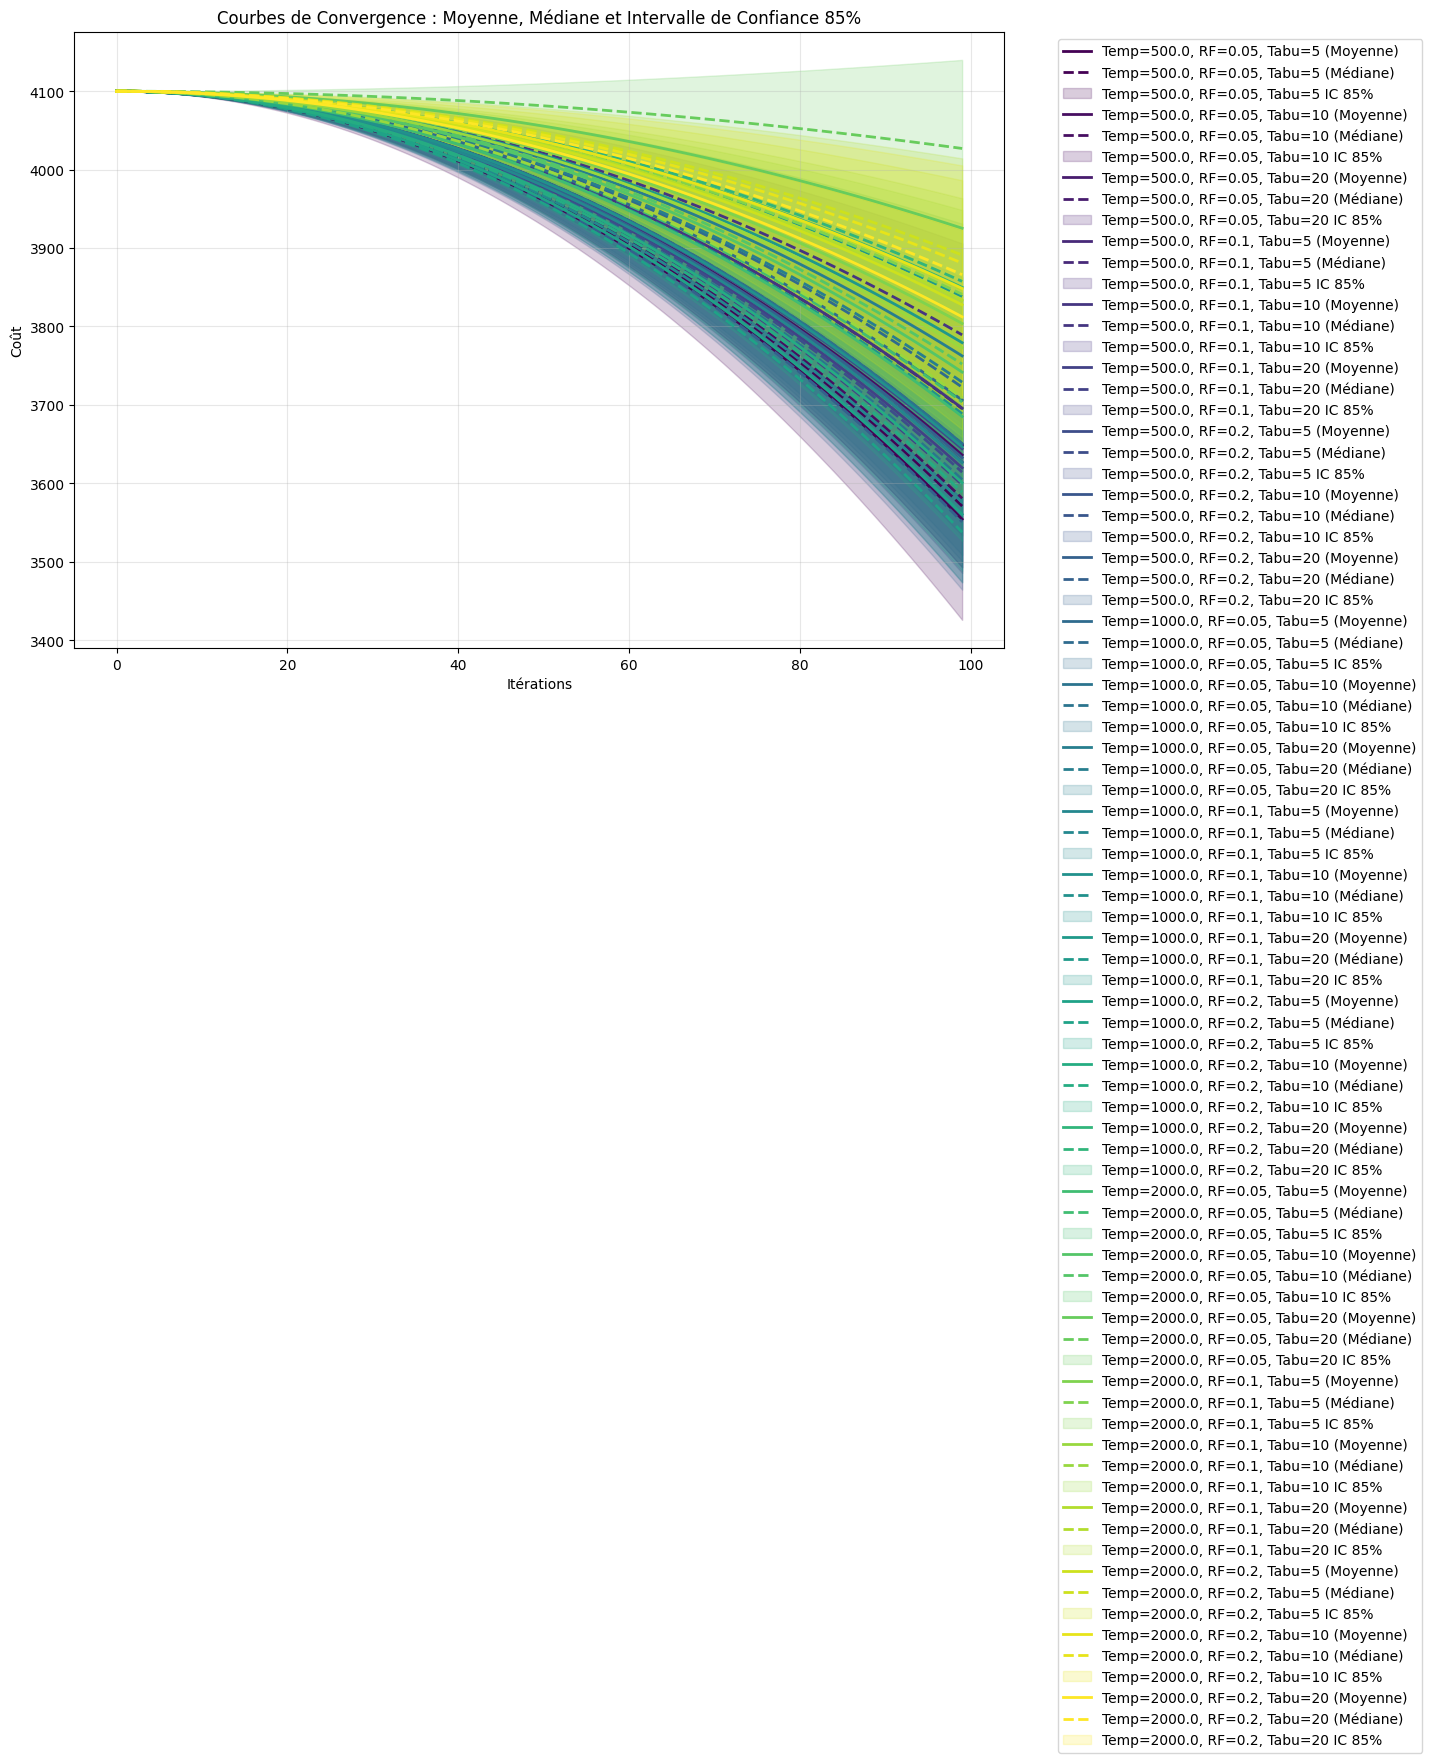

Données de convergence sauvegardées : stats/convergence_data.csv


In [8]:
# Génération des courbes de convergence
if results_by_params:
    plt.figure(figsize=(12, 8))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(results_by_params)))
    
    # Préparer les données pour sauvegarde CSV
    convergence_data = []
    
    for i, (params, results) in enumerate(results_by_params.items()):
        # Calculer la moyenne, médiane et écart-type des historiques de coût
        max_len = max(len(r['cost_history']) for r in results)
        padded_histories = []
        for r in results:
            hist = r['cost_history']
            if len(hist) < max_len:
                # Remplir avec la dernière valeur
                hist += [hist[-1]] * (max_len - len(hist))
            padded_histories.append(hist)
        
        avg_history = np.mean(padded_histories, axis=0)
        median_history = np.median(padded_histories, axis=0)
        std_history = np.std(padded_histories, axis=0)
        
        # Intervalle de confiance à 85% (approximatif avec 1.44 * std pour distribution normale)
        ci_85 = 1.44 * std_history
        
        iterations = range(len(avg_history))
        label = f"Temp={params[0]}, RF={params[1]}, Tabu={params[2]}"
        
        # Tracer la moyenne
        plt.plot(iterations, avg_history, label=f"{label} (Moyenne)", color=colors[i], linewidth=2)
        # Tracer la médiane
        plt.plot(iterations, median_history, label=f"{label} (Médiane)", color=colors[i], linewidth=2, linestyle='--')
        # Intervalle de confiance 85%
        plt.fill_between(iterations, avg_history - ci_85, avg_history + ci_85,
                        color=colors[i], alpha=0.2, label=f"{label} IC 85%")
        
        # Ajouter aux données CSV
        for it, (cost_mean, cost_median, std_val) in enumerate(zip(avg_history, median_history, std_history)):
            convergence_data.append({
                'Configuration': label,
                'Iteration': it,
                'Cout_Moyen': cost_mean,
                'Cout_Median': cost_median,
                'Ecart_Type': std_val,
                'IC_85_Bas': cost_mean - ci_85[it],
                'IC_85_Haut': cost_mean + ci_85[it]
            })
    
    plt.xlabel('Itérations')
    plt.ylabel('Coût')
    plt.title('Courbes de Convergence : Moyenne, Médiane et Intervalle de Confiance 85%')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Sauvegarder le graphique avant d'afficher
    os.makedirs('stats/plots', exist_ok=True)
    plt.savefig('stats/plots/convergence_curves_mean_median_ci.png', dpi=300, bbox_inches='tight')
    print("Graphique sauvegardé : stats/plots/convergence_curves_mean_median_ci.png")
    
    plt.show()
    
    # Sauvegarder les données de convergence en CSV
    df_convergence = pd.DataFrame(convergence_data)
    df_convergence.to_csv('stats/convergence_data.csv', index=False)
    print("Données de convergence sauvegardées : stats/convergence_data.csv")
else:
    print("Aucune donnée à tracer.")

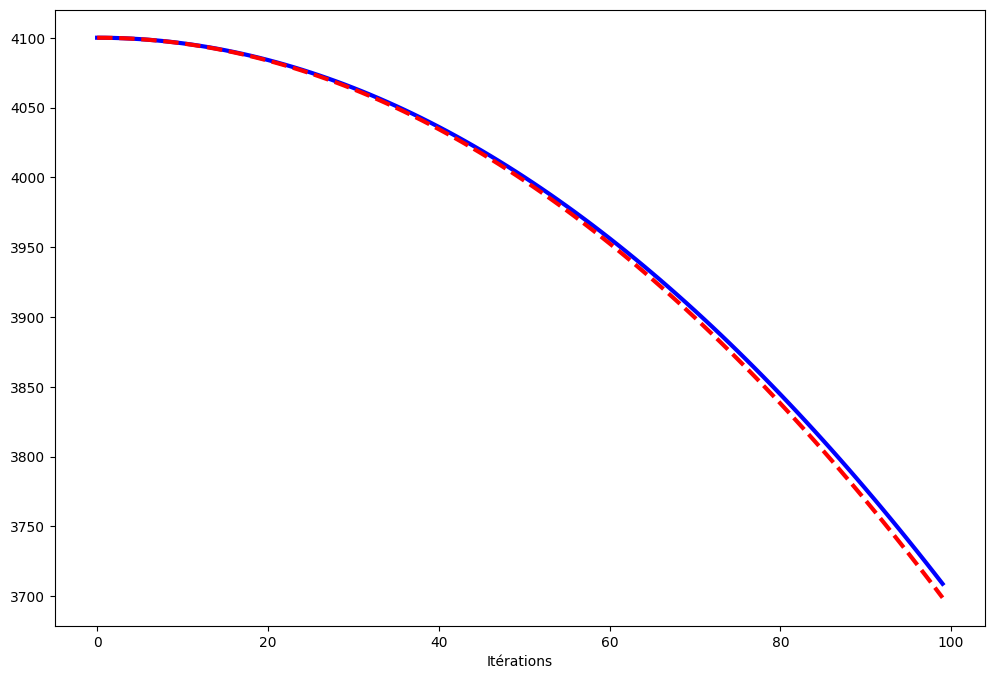

In [10]:
# Courbe de convergence globale : Moyenne et Médiane
if results_by_params:
    plt.figure(figsize=(12, 8))
    
    # Collecter tous les historiques
    all_histories = []
    for results in results_by_params.values():
        for r in results:
            all_histories.append(r['cost_history'])
    
    if all_histories:
        max_len = max(len(h) for h in all_histories)
        padded_all = []
        for h in all_histories:
            padded_all.append(h + [h[-1]] * (max_len - len(h)))
        
        global_mean = np.mean(padded_all, axis=0)
        global_median = np.median(padded_all, axis=0)
        
        iterations = range(len(global_mean))
        plt.plot(iterations, global_mean, label='Moyenne Globale', color='blue', linewidth=3)
        plt.plot(iterations, global_median, label='Médiane Globale', color='red', linewidth=3, linestyle='--')
        
        plt.xlabel('Itérations')

else:
    print("Aucune donnée à tracer.")

## Analyse des résultats statistiques

Nous analysons les coûts finaux moyens et identifions la meilleure configuration de paramètres.

In [11]:
# Analyse statistique des résultats
if results_by_params:
    # Calculer les statistiques pour chaque configuration
    stats_data = []
    for params, results in results_by_params.items():
        final_costs = [r['final_cost'] for r in results]
        times = [r['time'] for r in results]
        
        stats_data.append({
            'Température Initiale': params[0],
            'Facteur Réaction': params[1],
            'Durée Tabou': params[2],
            'Coût Final Moyen': np.mean(final_costs),
            'Écart-Type Coût': np.std(final_costs),
            'Temps Moyen (s)': np.mean(times),
            'Nombre Répétitions': len(results)
        })
    
    df_stats = pd.DataFrame(stats_data)
    print("Statistiques par Configuration :")
    print(df_stats.to_string(index=False, float_format='%.2f'))
    
    # Identifier la meilleure configuration
    best_idx = df_stats['Coût Final Moyen'].idxmin()
    best_config = df_stats.iloc[best_idx]
    print(f"\nMeilleure configuration :")
    print(f"  Température : {best_config['Température Initiale']}")
    print(f"  Facteur Réaction : {best_config['Facteur Réaction']}")
    print(f"  Durée Tabou : {best_config['Durée Tabou']}")
    print(f"  Coût Final Moyen : {best_config['Coût Final Moyen']:.2f}")
    
    # Sauvegarder les statistiques
    df_stats.to_csv('stats/parameter_stats.csv', index=False)
    print("Statistiques sauvegardées : stats/parameter_stats.csv")
    
    # Analyse de sensibilité
    sensitivity_data = []
    print("\nAnalyse de sensibilité :")
    for param in ['Température Initiale', 'Facteur Réaction', 'Durée Tabou']:
        grouped = df_stats.groupby(param)['Coût Final Moyen'].mean()
        print(f"  Impact de {param} :")
        for val, cost in grouped.items():
            print(f"    {val} -> {cost:.2f}")
            sensitivity_data.append({
                'Paramètre': param,
                'Valeur': val,
                'Coût_Moyen': cost
            })
    
    # Sauvegarder l'analyse de sensibilité
    df_sensitivity = pd.DataFrame(sensitivity_data)
    df_sensitivity.to_csv('stats/sensitivity_analysis.csv', index=False)
    print("Analyse de sensibilité sauvegardée : stats/sensitivity_analysis.csv")
else:
    print("Aucune donnée statistique disponible.")

Statistiques par Configuration :
 Température Initiale  Facteur Réaction  Durée Tabou  Coût Final Moyen  Écart-Type Coût  Temps Moyen (s)  Nombre Répétitions
               500.00              0.05            5           3554.23            89.19            10.00                   3
               500.00              0.05           10           3636.10            99.47            10.00                   3
               500.00              0.05           20           3648.42            79.81            10.00                   3
               500.00              0.10            5           3648.77           108.24            10.00                   3
               500.00              0.10           10           3695.75           145.91            10.00                   3
               500.00              0.10           20           3619.77            82.72            10.00                   3
               500.00              0.20            5           3643.96            93.94     

## Carte de chaleur des coûts moyens

Nous traçons une carte de chaleur montrant les coûts moyens pour chaque combinaison de température initiale et facteur de réaction, moyennés sur la durée tabou.

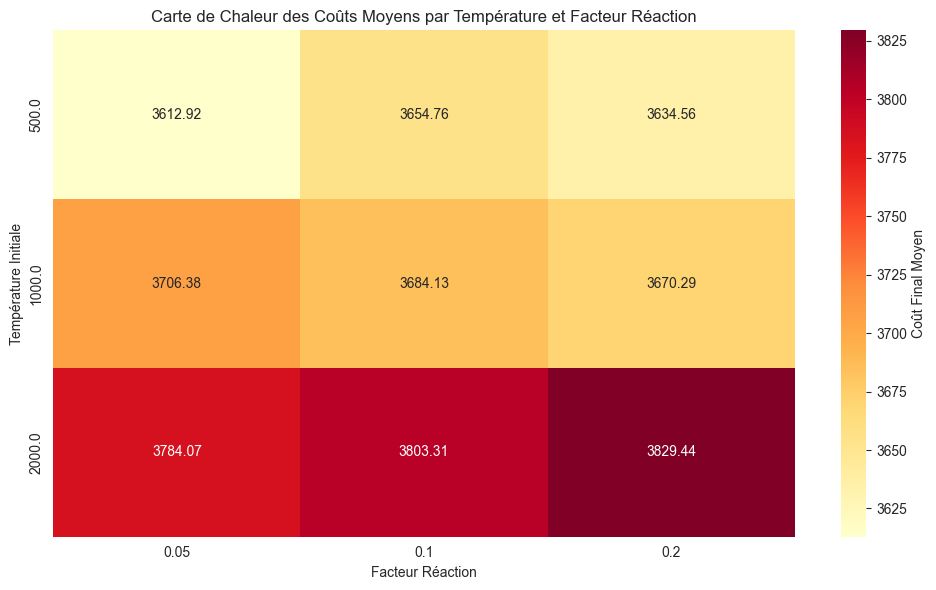

In [12]:
# Carte de chaleur des coûts moyens
if results_by_params:
    import seaborn as sns
    sns.set_style("whitegrid")
    
    plt.figure(figsize=(10, 6))
    heatmap_data = df_stats.pivot_table(index='Température Initiale', columns='Facteur Réaction', values='Coût Final Moyen', aggfunc='mean')
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlOrRd", cbar_kws={'label': 'Coût Final Moyen'})
    plt.title('Carte de Chaleur des Coûts Moyens par Température et Facteur Réaction')
    plt.xlabel('Facteur Réaction')
    plt.ylabel('Température Initiale')
    plt.tight_layout()
    plt.savefig('stats/plots/heatmap_temp_reaction.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Aucune donnée pour la carte de chaleur.")

## Boîtes à moustaches des distributions de coûts

Nous affichons des boîtes à moustaches pour visualiser la distribution des coûts finaux pour chaque valeur de paramètre.

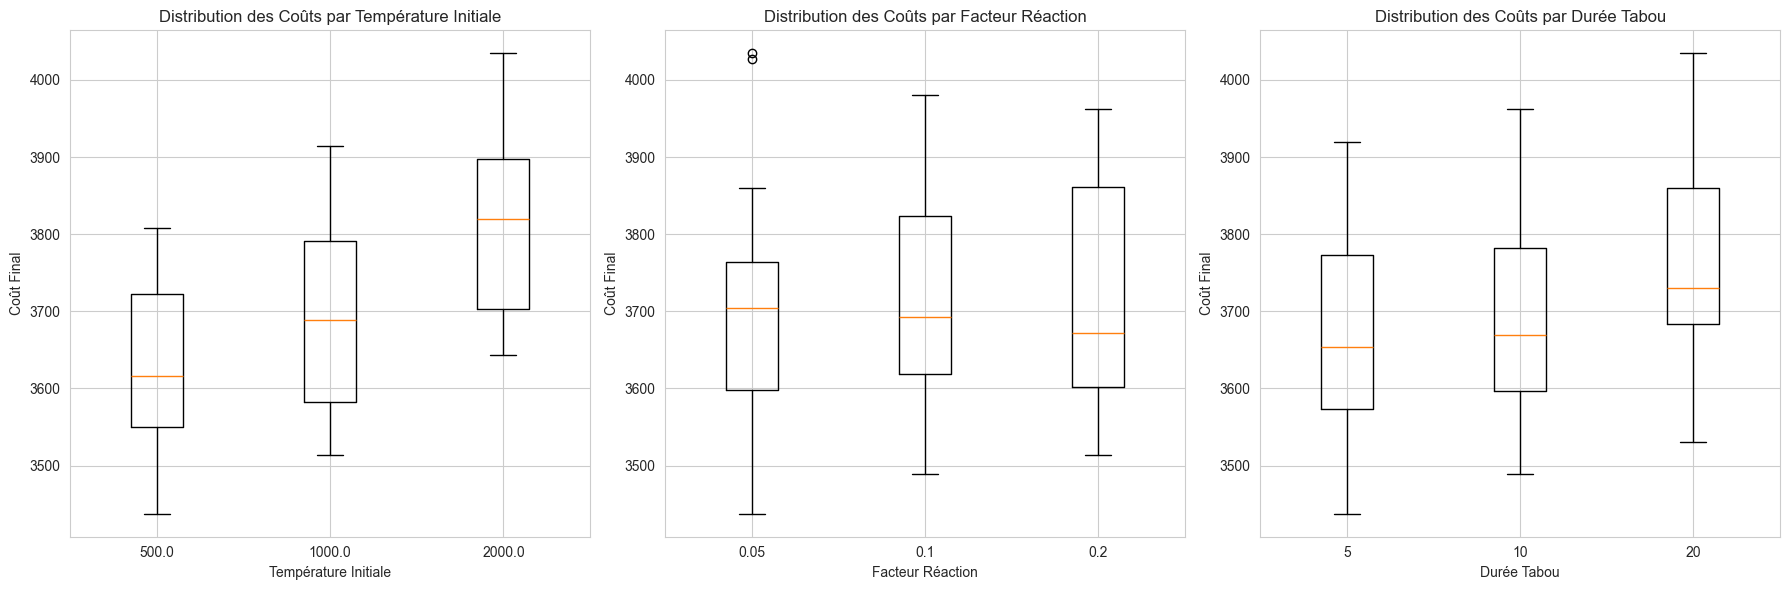

In [13]:
# Boîtes à moustaches des distributions de coûts
if results_by_params:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, param in enumerate(['Température Initiale', 'Facteur Réaction', 'Durée Tabou']):
        # Collecter les coûts pour chaque valeur du paramètre
        param_values = sorted(df_stats[param].unique())
        data_to_plot = []
        labels = []
        for val in param_values:
            costs = []
            for params, results in results_by_params.items():
                if (param == 'Température Initiale' and params[0] == val) or \
                   (param == 'Facteur Réaction' and params[1] == val) or \
                   (param == 'Durée Tabou' and params[2] == val):
                    costs.extend([r['final_cost'] for r in results])
            if costs:
                data_to_plot.append(costs)
                labels.append(str(val))
        
        axes[i].boxplot(data_to_plot, labels=labels)
        axes[i].set_title(f'Distribution des Coûts par {param}')
        axes[i].set_ylabel('Coût Final')
        axes[i].set_xlabel(param)
    
    plt.tight_layout()
    plt.savefig('stats/plots/boxplots_parameters.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Aucune donnée pour les boîtes à moustaches.")

## Histogramme des coûts finaux

Nous traçons un histogramme pour voir la distribution globale des coûts finaux de toutes les expériences.

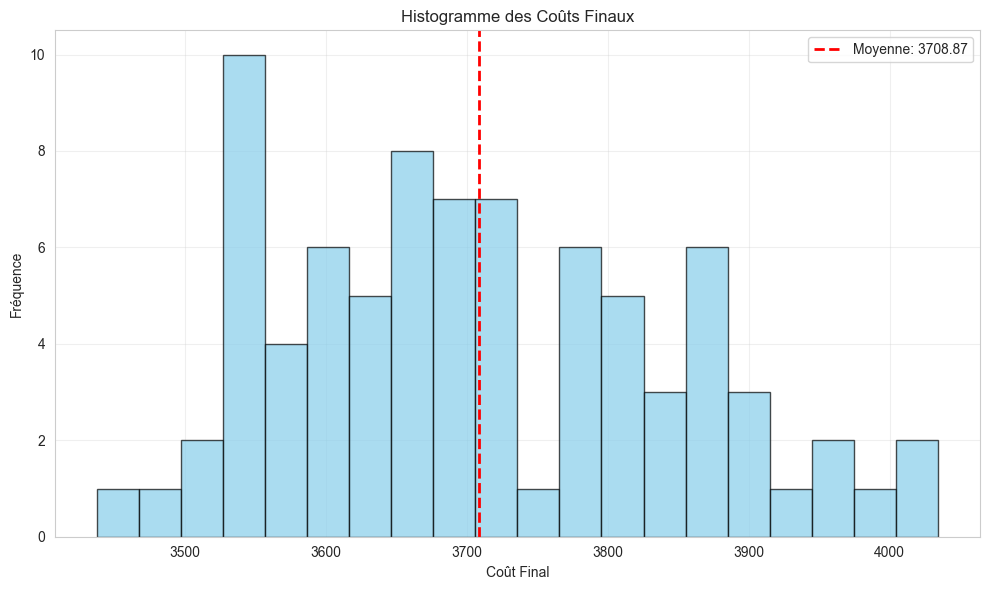

In [14]:
# Histogramme des coûts finaux
if results_by_params:
    plt.figure(figsize=(10, 6))
    all_final_costs = [r['final_cost'] for results in results_by_params.values() for r in results]
    plt.hist(all_final_costs, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(all_final_costs), color='red', linestyle='dashed', linewidth=2, label=f'Moyenne: {np.mean(all_final_costs):.2f}')
    plt.title('Histogramme des Coûts Finaux')
    plt.xlabel('Coût Final')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('stats/plots/histogram_costs.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Aucune donnée pour l'histogramme.")